In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

sys.path.append('..')

from sleeprnn.helpers import reader
from sleeprnn.data import utils
from sleeprnn.common import constants, pkeys, viz

viz.notebook_full_width()
%matplotlib inline

# Load dataset

In [2]:
dataset = reader.load_dataset(constants.ISRUC_SS_NAME)
fs = dataset.fs

Train size: 36.
Train subjects: 
 ['1-003', '1-004', '1-018', '1-027', '1-029', '1-031', '1-033', '1-036', '1-038', '1-046', '1-048', '1-050', '1-052', '1-053', '1-057', '1-058', '1-062', '1-065', '1-067', '1-069', '1-072', '1-076', '1-079', '1-087', '1-090', '1-092', '1-093', '1-098', '1-099', '3-001', '3-002', '3-006', '3-007', '3-008', '3-009', '3-010']
Dataset isruc_ss with 36 patients.
Loading from checkpoint... Loaded
Scaling signals to match global std 16.482042


# Visualize single page

In [49]:
subject_id = dataset.all_ids[4]
signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
marks = dataset.get_subject_stamps(subject_id, pages_subset=constants.N2_RECORD)
n2_pages = dataset.get_subject_pages(subject_id, pages_subset=constants.N2_RECORD)
print("Subject", subject_id)
print("Total spindle marks:", marks.shape[0])
print("Total N2 pages:", n2_pages.size)

Subject 1-029
Total spindle marks: 28
Total N2 pages: 415


In [50]:
def draw_single_page(n2_page_index_to_show, dpi):
    selected_page = n2_pages[n2_page_index_to_show]
    start_sample = int(selected_page * dataset.page_size)
    end_sample = start_sample + dataset.page_size

    segment_signal = signal[start_sample:end_sample]
    segment_marks = utils.filter_stamps(marks, start_sample, end_sample)
    sigma_signal = utils.broad_filter(segment_signal, fs, lowcut=11, highcut=16)
    time_axis = np.arange(start_sample, end_sample) / fs

    fig, axes = plt.subplots(2, 1, figsize=(12, 4), dpi=dpi, sharex=True, sharey=True)

    axes[0].set_title("Subject %s, page in record %d" % (subject_id, selected_page))
    axes[0].plot(time_axis, segment_signal, linewidth=0.6)
    axes[1].plot(time_axis, sigma_signal, linewidth=0.6)
    for ax in axes.flatten():
        ax.set_ylim([-150, 150])
        ax.set_xlim([start_sample/fs, end_sample/fs])
        for mark in segment_marks:
            mark = np.clip(mark, a_min=start_sample, a_max=end_sample)
            ax.plot(mark / fs, [-50, -50], linewidth=5, alpha=0.5, color=viz.PALETTE['red'])
        ax.set_xticks(np.linspace(start_sample/fs, end_sample/fs, 41), minor=True)
        ax.grid(axis="x", which="minor")
    plt.tight_layout()
    plt.show()

    # power, freq = utils.power_spectrum(segment_signal, fs)
    # fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
    # ax.plot(freq, power, linewidth=0.7)
    # ax.set_xlim([0, 30])
    # ax.set_xlabel("Frequency (Hz)")
    # plt.show()

In [52]:
n2_page_index_to_show = 0 # 110


dpi = 100
print('Total N2 pages: %d' % n2_pages.size)
style = {'description_width': 'initial'}
layout= widgets.Layout(width='1000px')
widgets.interact(
    lambda page_id: draw_single_page(page_id, dpi=dpi),
    page_id=widgets.IntSlider(
        min=0, max=n2_pages.size-1, step=1, value=n2_page_index_to_show, 
        continuous_update=False,
        style=style,
        layout=layout
    ));

Total N2 pages: 415


A Jupyter Widget

# Check duration histogram

In [53]:
marks_list = dataset.get_stamps(pages_subset=constants.N2_RECORD)

In [55]:
marks = np.concatenate(marks_list, axis=0)
print(marks.shape)

(9460, 2)


In [56]:
durations = (marks[:, 1] - marks[:, 0]) / fs

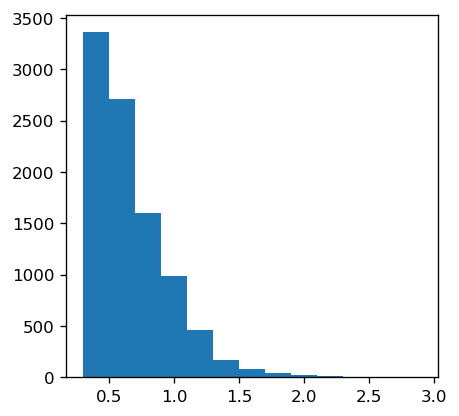

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=120)
ax.hist(durations, bins=np.arange(0.3, 3.001, 0.2))
plt.show()

In [62]:
np.sum(durations < 0.5)

3363

In [86]:
thr = 0.5
all_msg = []
all_fractions = []
all_means = []
for subject_id, subject_marks in zip(dataset.all_ids, marks_list):
    subject_durations = (subject_marks[:, 1] - subject_marks[:, 0]) / fs
    mean_duration = np.mean(subject_durations)
    msg = "Suject %s: %3d SS marks, %3d less than %ss (%1.2f%%). Mean duration: %1.3fs" % (
        subject_id, subject_durations.size, np.sum(subject_durations < thr), thr, 100 * np.sum(subject_durations < thr) / subject_durations.size, mean_duration)
    all_msg.append(msg)
    all_fractions.append(-100 * np.sum(subject_durations < thr) / subject_durations.size)
    all_means.append(mean_duration)
idx_sorted = np.argsort(all_fractions)
all_msg = [all_msg[i] for i in idx_sorted]
for msg in all_msg:
    print(msg)
    
print("\n Mean of means in duration: %1.3fs" % np.mean(all_means))
print("Mean of all durations aggregated: %1.3fs" % np.mean(durations))

Suject 1-053:   8 SS marks,   7 less than 0.5s (87.50%). Mean duration: 0.420s
Suject 1-029:  28 SS marks,  21 less than 0.5s (75.00%). Mean duration: 0.520s
Suject 1-046: 124 SS marks,  81 less than 0.5s (65.32%). Mean duration: 0.608s
Suject 1-057:  29 SS marks,  18 less than 0.5s (62.07%). Mean duration: 0.564s
Suject 1-031:  23 SS marks,  14 less than 0.5s (60.87%). Mean duration: 0.530s
Suject 1-093: 159 SS marks,  92 less than 0.5s (57.86%). Mean duration: 0.577s
Suject 1-067: 170 SS marks,  96 less than 0.5s (56.47%). Mean duration: 0.566s
Suject 1-058: 476 SS marks, 262 less than 0.5s (55.04%). Mean duration: 0.599s
Suject 3-006: 114 SS marks,  62 less than 0.5s (54.39%). Mean duration: 0.557s
Suject 1-092: 150 SS marks,  77 less than 0.5s (51.33%). Mean duration: 0.619s
Suject 1-087: 145 SS marks,  73 less than 0.5s (50.34%). Mean duration: 0.601s
Suject 1-065:  36 SS marks,  18 less than 0.5s (50.00%). Mean duration: 0.598s
Suject 1-036: 126 SS marks,  62 less than 0.5s (49.2